In [2]:
# !pip install pamda

In [3]:
# Finally I found a way to run fema_model on public device


# !pip install gdown
# folder_id = "1RMi5T81IxGm5d1h3qmzyTVWs906UXNwG"
# !gdown --folder https://drive.google.com/drive/folders/{folder_id}
# !pip install ./fema_model

In [4]:
# from google.colab import drive
# drive.mount('fema-fl-data-SR_Branch')

In [5]:
# !pip install /content/fema-fl-data-SR_Branch/MyDrive/GitHub/fema-fl-data-SR_Branch/fema_model

In [6]:
from pamda import pamda as p
from fema_model import Multi_Period_Terminal_System
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm


In [7]:
geo_areas = p.read_json('geo_areas.json')

In [8]:
groups_df = pd.read_excel('NMSZ_Groups.xlsx')
groups = groups_df['group_name'].values
terminals_df = pd.read_excel('NMSZ_Terminals.xlsx')
stations_df = pd.read_excel('NMSZ_Stations.xlsx')

In [9]:
# Fixed parameters
# Bay queue space
b_q = 3
# Time to empty fuel at station (mins)
r_s = 60
# Bounds of time to empty fuel at station (mins)
r_s_bound = 10
# Truck start time max (hrs)
a = 6
# Truck capacity (gallons)
c = 9000
# Truck stopping criteria (hr)
tau = 0.5

# Flexible parameters
# Gate check-in time (mins)
# Baseline
r_g = 7
# Disruption
# r_g = 10.5
# r_g = 8.4
# Intervention
# r_g = 3.5
# Bounds multiplier of gate check-in time (mins)
r_g_bound = 0.1
# Bay filling time (mins)
# Baseline
r_b = 35
# Disruption
# r_b = 52.5
# r_b = 42
# Intervention
# r_b = 17.5
# Bounds multiplier of bay filling time (mins)
r_b_bound = 0.1
# Truck speed (mph)
# Baseline
v = 45
# Disruption
# v = 22.5
# v = 36
# Intervention
# v = 67.5
# Bounds multiplier of truck speed (mph)
v_bound = 0.1
# Hours of service (hrs)
# Baseline
h = 14
# HoS extension
# h = 18

# Iterations
itrn = 50

# Final outputs for all groups
ops_df = pd.DataFrame(columns = ['Iteration', 'Group', 'Flow', 'Flow_MMgal', 'Trips_Per_Truck', 'Gate_Queue_Wait', 'Driving_Time'])

# Input kwargs
inputs = {
    'carry_over_demand_multiplier':0,
    'default_kwargs':{
        'demand_situation':'dem_scen_1',
        'demand_multiplier':1,
        'truck_multiplier':1,
        'station_algorithm':'max',
        'truck_kwargs':{
            'size':c,
            'speed':v,
            'speed_sigma':v*v_bound,
            'empty_rate':r_s,
            'empty_rate_sigma':r_s_bound,
            'open_time_min':0,
            'open_time_max':a,
            'close_time_after_open':h,
            'close_early_delta':tau
        },
        'station_kwargs':{
            'open_time':0,
            'close_time':24,
        },
        'terminal_kwargs':{
            'gate_kwargs':{
                'gate_rate':r_g,
                'gate_rate_sigma':r_g*r_g_bound,
                'open_time':0,
                'close_time':24,
                'extra_gates':0,
                'max_gate_queue':None, #Infinite
                'share_gate_queue_bool':True
            },
            'bay_kwargs':{
                'open_time':0,
                'close_time':24,
                'fill_rate':r_b,
                'fill_rate_sigma':r_b*r_b_bound,
                'extra_bays':0,
                'max_bay_queue':b_q,
                'share_bay_queue_bool':True
            }
        }
    }
}

# Selected terminal interventions
inputs['terminal_kwargs'] = {}

# Create terminal systems dictionary
terminal_system_data = {}
for i in range(len(groups)):
    terminal_system_data[groups[i]] = {}
    # Baseline
    terminal_system_data[groups[i]]['trucks_available'] = int(groups_df['trucks'][i])
    # Disruption
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.5))
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.8))
    # Fixed fleet intervention
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.5))+20
    # Fleet intervention
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.75))
    terms = terminals_df[terminals_df['group_name'] == groups[i]]['terminal_id'].values
    terminal_system_data[groups[i]]['terminals'] = {}
    for j in range(len(terms)):
        terminal_system_data[groups[i]]['terminals'][terms[j]] = {}
        terminal_system_data[groups[i]]['terminals'][terms[j]]['fuel_types'] = 'a'
        terminal_system_data[groups[i]]['terminals'][terms[j]]['num_gates'] = int(terminals_df[terminals_df['terminal_id'] == terms[j]]['num_gates'].values[0])
        terminal_system_data[groups[i]]['terminals'][terms[j]]['num_bays'] = int(terminals_df[terminals_df['terminal_id'] == terms[j]]['num_bays'].values[0])
        # Terminal interventions for 2 largest terminal in the group
        # if(j >= len(terms)-2):
        #     inputs['terminal_kwargs'][terms[j]] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs']['gate_rate'] = 3.5
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs']['fill_rate'] = 17.5
        # Terminal interventions for largest terminal in the group
        # if(j == len(terms)-1):
        #     inputs['terminal_kwargs'][terms[j]] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs']['gate_rate'] = 3.5
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs']['fill_rate'] = 17.5

for l in tqdm(range(itrn)):
    op_flow = np.zeros((len(groups),))
    op_trips = np.zeros((len(groups),))
    op_gate_wait = np.zeros((len(groups),))
    op_driving = np.zeros((len(groups),))
    for i in range(len(groups)):
        stn = stations_df[stations_df['group_name'] == groups[i]]
        stn = shuffle(stn).reset_index()
        terminal_system_data[groups[i]]['stations'] = {}
        for k in range(len(stn)):
            station_name = stn['station_id'][k]
            terminal_system_data[groups[i]]['stations'][station_name] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['travel_distance'] = stn['station_group_dist'][k]
            terminal_system_data[groups[i]]['stations'][station_name]['geo_code'] = '1'
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios'] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1'] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1']['demand'] = c
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1']['fuel_types'] = ['a']
    periods = [inputs]
    model = Multi_Period_Terminal_System(terminal_system_data = terminal_system_data, geo_areas = geo_areas, periods = periods)
    output = model.serialize(minify = True)
    for i in range(len(groups)):
        op_flow[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['sum_met_total_demand']),3)
        op_trips[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_deliveries_made']),3)
        op_gate_wait[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['trip_avg_in_gate_queue']),3)
        op_driving[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_to_station'] +\
                               output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_to_terminal_group']),3)
    op_df1 = pd.DataFrame(columns = ['Iteration', 'Group', 'Flow', 'Flow_MMgal', 'Trips_Per_Truck', 'Gate_Queue_Wait', 'Driving_Time'])

    op_df1['Flow'] = op_flow
    op_df1['Flow_MMgal'] = op_flow/(10**6)
    op_df1['Trips_Per_Truck'] = op_trips
    op_df1['Gate_Queue_Wait'] = op_gate_wait
    op_df1['Driving_Time'] = op_driving
    op_df1['Iteration'] = l
    op_df1['Group'] = groups
    ops_df = pd.concat([ops_df, op_df1], ignore_index=True)

# Baseline
ops_df.to_csv('2025-02-15_NMSZ_Four_Metro_Areas_Results.csv')
# Gate intervention
# ops_df.to_csv('2024-12-25_NMSZ_No_Memphis_Results_Gate_intervention.csv')

# print("File saved as 2024-11-27_NMSZ_Baseline_Results.csv")
# Disruption
# ops_df.to_csv('2022-03-15_Florida_Disruption2_Results.csv')
# Disruption + HoS extension
# ops_df.to_csv('2022-03-15_Florida_Disruption2_HoS_Results.csv')
# Disruption + HoS extension + single terminal intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_1_Terminal_Results.csv')
# Disruption + HoS extension + two terminals intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_2_Terminals_Results.csv')
# Disruption + HoS extension + all terminals intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Terminals_Results.csv')
# Disruption + HoS extension + speed intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Speed_Results.csv')
# Disruption + HoS extension + fixed fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Fixed_Fleet_Results.csv')
# Disruption + HoS extension + fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Fleet_Results.csv')
# Disruption + HoS extension + speed + fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Speed_Fleet2_Results.csv')
# Disruption + all intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_All_Interventions2_Results.csv')

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-9-3c9517c6747d>:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ops_df = pd.concat([ops_df, op_df1], ignore_index=True)
100%|██████████| 50/50 [04:05<00:00,  4.91s/it]


In [10]:
print("File saved as 2025-02-15_NMSZ_4_metro_areas_baseline_Results.csv")

File saved as 2025-02-15_NMSZ_4_metro_areas_baseline_Results.csv


In [11]:
ops_df

,Iteration,Group,Flow,Flow_MMgal,Trips_Per_Truck,Gate_Queue_Wait,Driving_Time
0,0,Evansville,693000.0,0.693,1.711,0.000,5.865
1,0,Little Rock,3330000.0,3.330,2.403,0.007,4.767
2,0,Memphis,3384000.0,3.384,1.573,1.435,4.018
3,0,St. Louis,2664000.0,2.664,1.184,3.289,1.797
4,1,Evansville,747000.0,0.747,1.844,0.000,5.541
...,...,...,...,...,...,...,...
195,48,St. Louis,2682000.0,2.682,1.173,3.399,1.817
196,49,Evansville,693000.0,0.693,1.711,0.000,5.821
197,49,Little Rock,3420000.0,3.420,2.468,0.006,5.122
198,49,Memphis,3267000.0,3.267,1.545,1.593,3.571


In [12]:
# Group by 'Group' and describe aggregated statistics
grouped_description = ops_df.groupby('Group').describe()

# Display the result
print(grouped_description)


             Flow                                                            \
            count       mean           std        min        25%        50%   
Group                                                                         
Evansville   50.0   707040.0  34073.126642   639000.0   693000.0   702000.0   
Little Rock  50.0  3244680.0  70520.930458  3078000.0  3213000.0  3240000.0   
Memphis      50.0  3320280.0  52756.289885  3213000.0  3285000.0  3316500.0   
St. Louis    50.0  2665800.0  24597.162604  2610000.0  2646000.0  2664000.0   

                                  Flow_MMgal           ... Gate_Queue_Wait  \
                   75%        max      count     mean  ...             75%   
Group                                                  ...                   
Evansville    729000.0   801000.0       50.0  0.70704  ...          0.0000   
Little Rock  3291750.0  3420000.0       50.0  3.24468  ...          0.0070   
Memphis      3357000.0  3429000.0       50.0  3.32028  .

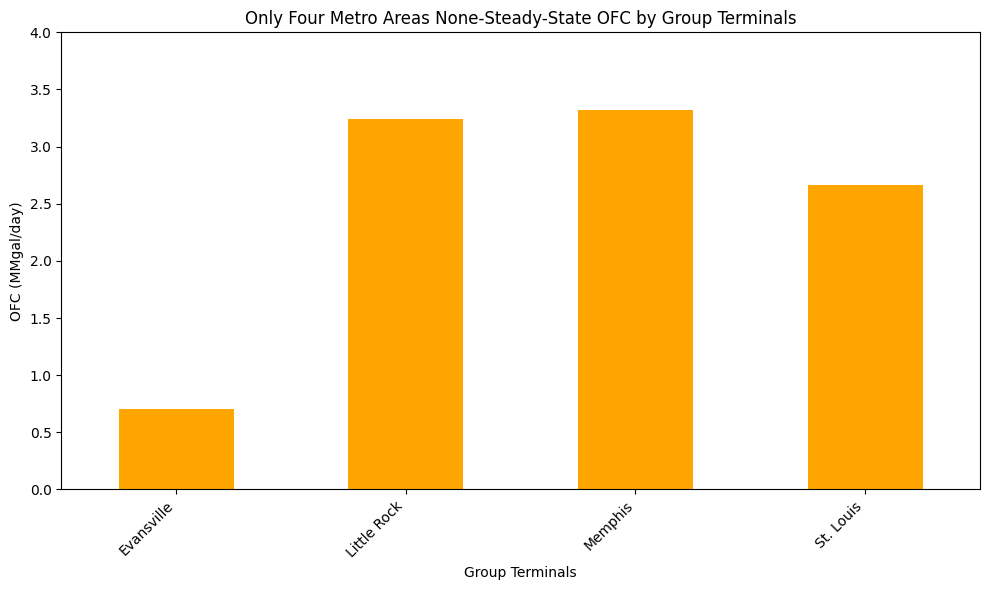

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Average of 'Flow' for each group
flow_avg = ops_df.groupby('Group')['Flow'].mean()


ax = flow_avg.plot(kind='bar', figsize=(10, 6), title='Only Four Metro Areas None-Steady-State OFC by Group Terminals', color='orange')
ax.set_ylabel('OFC (MMgal/day)')
ax.set_xlabel('Group Terminals')

# Custom tick formatting to display values in millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1_000_000:,.1f}'))  # Convert to millions and format to 1 decimal

# Set Y-axis limits
ax.set_ylim(0, 4000000)  # Set maximum Y-axis value to 6.5

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
